In [1]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict, defaultdict

import scipy.stats as scs
import seaborn as sns; sns.set()

import matplotlib.pyplot as plta
import matplotlib.colors as colors

import sys
import os 

import scipy as sp
from scipy.linalg import eig 
import matplotlib


from contextlib import suppress

import itertools

from tqdm import tqdm

# import cassiopeia.TreeSolver.post_process_tree as ppt -- dont need
from cassiopeia.Analysis import reconstruct_states
from cassiopeia.TreeSolver.Node import Node
# import cassiopeia.TreeSolver.compute_meta_purity as cmp -- dont need
from cassiopeia.Analysis import small_parsimony
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree

# from utilities import seeding_patterns -- cannot find


from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# import umap -- dont need
# import numba - dont need


## Read in lineage groups

In [2]:
def newick_to_network(newick_filepath, cm, f=1):
    """
	Given a file path to a newick file, convert to a directed graph.

	:param newick_filepath:
		File path to a newick text file
    :param cm:
        Character matrix (???)
	:param f:
		Parameter to be passed to Ete3 while reading in the newick file. (Default 1)
	:return: a networkx file of the tree
	"""

    G = nx.DiGraph()  # the new graph
    cm_lookup = cm.apply(lambda x: "|".join(x.values), axis=1)

    try:
        tree = Tree(newick_filepath, format=f)
    except:
        tree = Tree(newick_filepath)

    # Create dict from ete3 node to cassiopeia.Node
    e2cass = {}
    for n in tree.traverse("postorder"):

        if "|" in n.name:
            nn = Node("state-node", n.name.split("|"), support=n.support)
        elif n.name != "" or "Inner" in n.name:
            nn = Node(n.name, [], support=n.support)
        else:
            nn = Node("state-node", [], support=n.support)

        if n.is_leaf() and nn.char_string in cm_lookup:
            nn.is_target = True

        e2cass[n] = nn
        G.add_node(nn)

    for p in tree.traverse("postorder"):

        pn = e2cass[p]

        for c in p.children:
            cn = e2cass[c]

            G.add_edge(pn, cn)

    return G
  

In [3]:
# lg_meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

# home_dir = '/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/'

lg_meta = pd.read_csv("./data/GSM4905335_meta.5k.tsv", sep='\t', index_col = 0)

home_dir = './data/trees/'

print(len(tqdm(os.listdir(home_dir))))

lg_to_tree = {}
lg_to_cm = {}
for fp in tqdm(os.listdir(home_dir)):
    if "tree_hybrid_priors.alleleThresh.processed.txt" not in fp:
        continue
    
    lg = fp.split("_")[1][2:]
        
    cmfp = "./data/character_matrices/" + fp.replace("tree_hybrid_priors", "character_matrix").replace(".processed","")
    cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
    
    fp = home_dir + fp    
    
    # From other file
    tree = Cassiopeia_Tree('from_newick', network = newick_to_network(fp, cm))
    lg_to_tree[int(lg)] = tree.post_process(cm)
    

    lg_to_cm[int(lg)] = cm
    
#     fps = [fp for fp in os.listdir(tree_dir) if "alleleThresh.pkl" in fp and "tree" in fp and 'nj' not in fp]
#     cms = [fp for fp in os.listdir(tree_dir) if 'character_matrix.alleleThresh.txt' in fp]

#     if len(fps) > 0:
        
#         try:
#             tree = pic.load(open((tree_dir + fps[0]), 'rb'))
#             lg_to_tree[int(lg)] = tree
            
#             lg_to_cm[int(lg)] = pd.read_csv(tree_dir + cms[0], sep='\t', index_col = 0)
#         except:
#             continue

  0%|                                                   | 0/245 [00:00<?, ?it/s]


245


100%|█████████████████████████████████████████| 245/245 [00:31<00:00,  7.81it/s]


## Form Transition Matrices

In [18]:
def plot_trans_matrix(count_arr, vmin=0, vmax=1.0, ax=None):
    if ax is None:
        ax = plt.gca()
    res = count_arr.loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
    g = sns.heatmap(res, mask = np.eye(6), cmap="Reds", square=True, ax=ax, vmin = vmin, vmax=vmax, cbar=True)
    return g

def plus_one_counting(x, k=0.2):
    return (x + k) / (x.sum() + x.shape[0] * k)

100%|███████████████████████████████████████████| 82/82 [03:04<00:00,  2.26s/it]


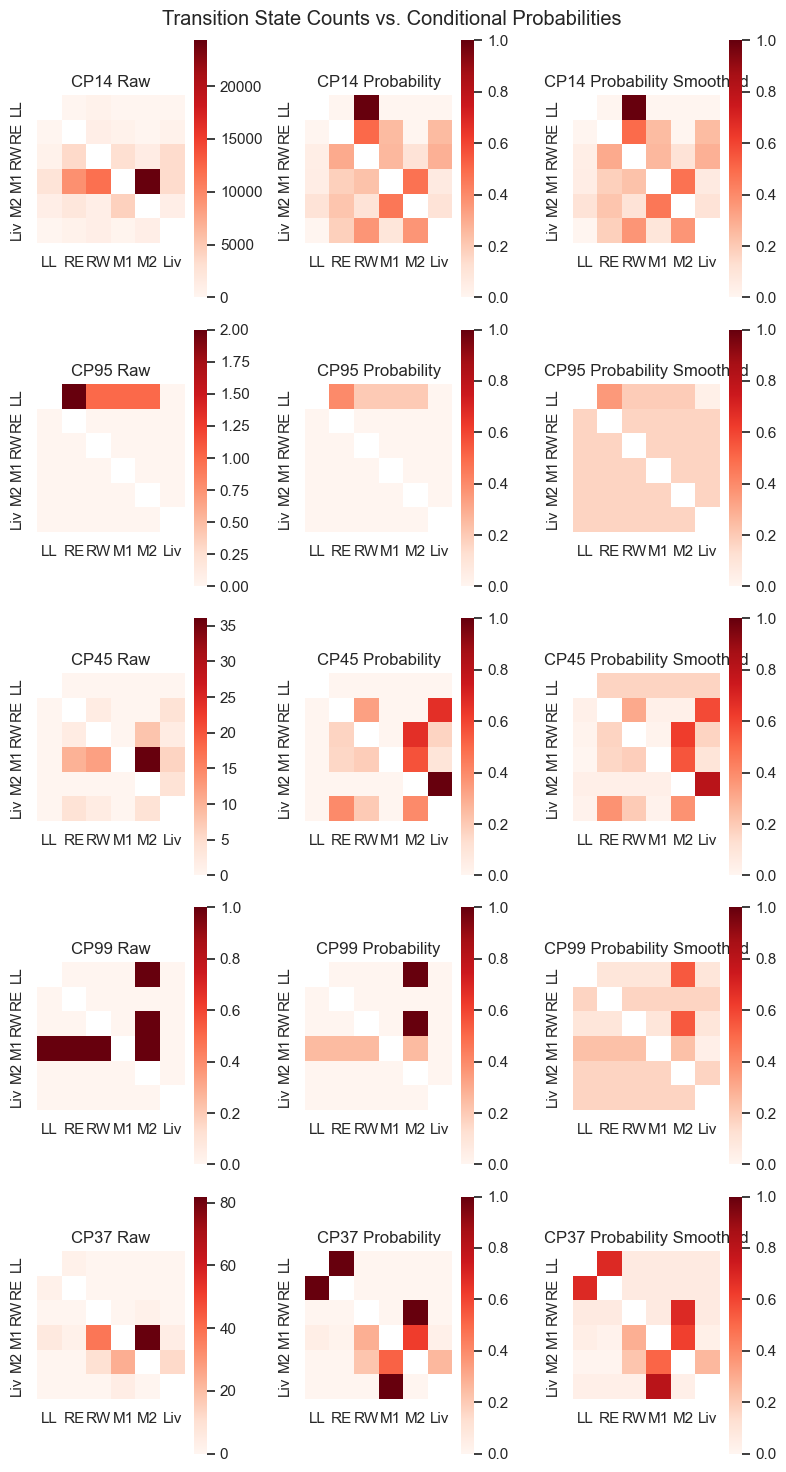

In [90]:
fig, axs = plt.subplots(5,3, figsize=(8,15))
count_arrs = []
count_arrs_orig = []
count_arrs_plus_one = []
lgs = []
# diag_density = []
# LL_density = []
# M1_density = []
# M2_density = []
# LL_stay = []
# RW_stay = []
# RE_stay = []
# Liv_stay = []
# M1_stay = []
# M2_stay = []

ks = [0, 0.1, 0.2, 0.5, 1.0]

bidirectional_reseeding = {}
to_drop = [33, 5, 69, 39, 38, 41, 75, 16, 18, 50, 53, 87, 88, 25, 93, 65, 81]

count = 0
for _lg in tqdm(lg_to_tree.keys()):
    
    if _lg in to_drop:
        continue
    
    lg = lg_to_tree[_lg]
    cm = lg_to_cm[_lg]

    plg = lg.post_process(cm).network
    
    
    count_arr = reconstruct_states.fitch_count(plg, lg_meta['sampleID'])
    
    
    
    
#     tot = np.sum(count_arr.sum())
#     diag_density.append(np.sum([count_arr.iloc[i, i] / tot for i in range(count_arr.shape[0])]))


    np.fill_diagonal(count_arr.values,0)
#     tot = np.sum(count_arr.sum())
#     LL_density.append(np.sum([count_arr.loc['LL', i] / tot for i in count_arr.columns]))
#     M1_density.append(np.sum([count_arr.loc['M1', i] / tot for i in count_arr.columns]))
#     M2_density.append(np.sum([count_arr.loc['M2', i] / tot for i in count_arr.columns]))

    count_arr_orig = count_arr.apply(lambda x: x / max(1, x.sum()), axis=1) # if x.sum() > 10 else x * np.nan, axis=1)
    count_k_arrs = {}
    for k in ks:
        count_arr_plus_k = count_arr.apply(plus_one_counting, axis=1, args=(k,)) #lambda x: x / max(1, x.sum()))# if x.sum() > 10 else x * np.nan, axis=1)
        count_k_arrs[k] = count_arr_plus_k 
    count_arr_plus_one = count_k_arrs[0.2]
    count_arrs.append(count_arr)
#     count_arrs_orig.append(count_arr_orig)
    count_arrs_plus_one.append(count_k_arrs)
#     count_arrs_plus_one.append(count_arr_plus_one)
    lgs.append(_lg)

    if count <= 4:
        plot_trans_matrix(count_arr, vmin=0, vmax=np.max((1 - np.eye(6)) * count_arr.values), ax=axs[count][0])
        plot_trans_matrix(count_arr_orig, ax=axs[count][1])
        plot_trans_matrix(count_arr_plus_one, ax=axs[count][2])
        axs[count][0].set_title("CP%d Raw" % _lg)
        axs[count][1].set_title("CP%d Probability" % _lg)
        axs[count][2].set_title("CP%d Probability Smoothed" % _lg)
#     else:
#         break
    count += 1
        
fig.suptitle("Transition State Counts vs. Conditional Probabilities")
fig.tight_layout()
plt.show()

In [51]:
# create a dataframe to track different topologies
topo_df = pd.DataFrame(index = lgs)
topo_df['PrimarySeeding'] = False
topo_df['SeedingCascade'] = False
topo_df['ParallelSeeding'] = False
topo_df['Reseeding'] = False
topo_df['BiDirectionalReseeding'] = False
topo_df['SeedingCascade'] = False

for n in lgs:
    transmat = lg_to_countarr[n]
    
    
    # record seeding cascade
    for i in transmat.index:
        if i != 'LL':
            for j in transmat.columns:
                if j != 'LL' and transmat.loc[i, j] > 0:
                    topo_df.loc[n, 'SeedingCascade'] = True
        
#     topo_df.loc[n, 'BiDirectionalReseeding'] = bidirectional_reseeding[n]
    
    # detect reseeding
    if np.sum(transmat['LL']) > 0:
        topo_df.loc[n, 'Reseeding'] = True
        topo_df.loc[n, 'BiDirectionalReseeding'] = True
                
    # record primary seeding
    if np.sum(transmat.sum()) > 0 or ("LL" not in lg_meta.loc[lg_meta['LineageGroup'] == n, 'sampleID'].unique()):
        topo_df.loc[n, 'PrimarySeeding'] = True
        
        
    # record parallel seeding
    for i in transmat.index:
        dens_arr = np.where(transmat.loc[i] > 0)[0]
        if len(dens_arr) > 1:
            topo_df.loc[n, 'ParallelSeeding'] = True

topo_df.to_csv("lineage_topology.5k.txt", sep='\t')

In [33]:
topo_df_old = pd.read_csv("data/5k/lineage_topology.5k.txt", sep='\t', index_col = 0)
i = 0
for lg in topo_df_old.index:
    
    old, new = topo_df_old.loc[lg].iloc[:5], topo_df.loc[lg].iloc[:5]
    if not np.array_equal(old, new):
        i += 1
print(i)

83


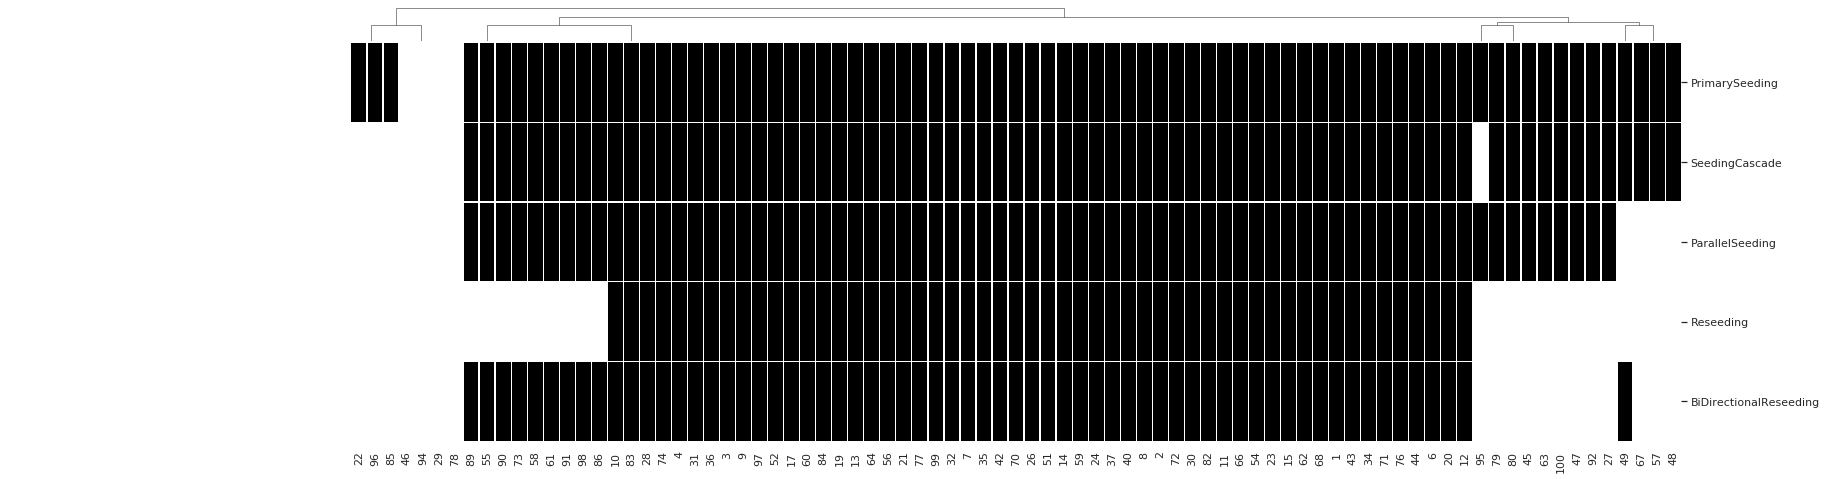

In [53]:
topo_df = pd.read_csv("lineage_topology.5k.txt", sep='\t', index_col = 0)

sns.set(font_scale=1)
# topo_df = topo_df.iloc[:, :5]
cm = sns.clustermap(topo_df.T, cmap = 'Greys', row_cluster=False, figsize = (30, 8), linewidths=.25)
cm.cax.set_visible(False) 

plt.savefig('lineage_topology.5k.eps')

## Summarize transition matrices

In [109]:
arr = count_arrs_plus_one[i][k_arg]
print(arr)
arr.sum(axis=1)
print(arr.T[["RW"]].sum())

           RW        RE        M2        M1       Liv        LL
RW   0.125000  0.125000  0.375000  0.125000  0.125000  0.125000
RE   0.125000  0.125000  0.125000  0.125000  0.125000  0.375000
M2   0.211538  0.019231  0.019231  0.480769  0.250000  0.019231
M1   0.282609  0.021739  0.601449  0.007246  0.036232  0.050725
Liv  0.100000  0.100000  0.100000  0.500000  0.100000  0.100000
LL   0.125000  0.375000  0.125000  0.125000  0.125000  0.125000
RW    1.0
dtype: float64


-0.2993725379514633 0.18197154267637808
0.4472282778224055 -0.2718446394606771
0.5075941609964287 -0.30853762727233736
0.5882467803341753 -0.3575617684384194
-0.616461795329532 0.37471207167089043


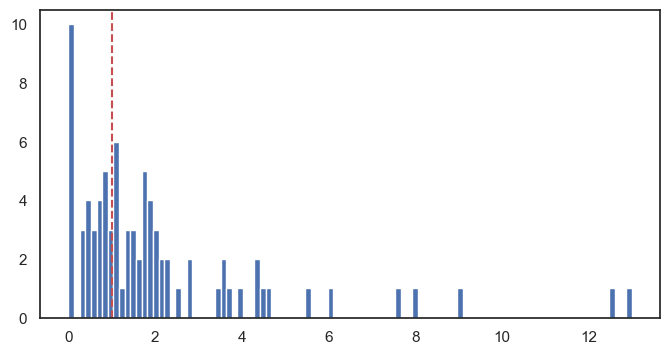

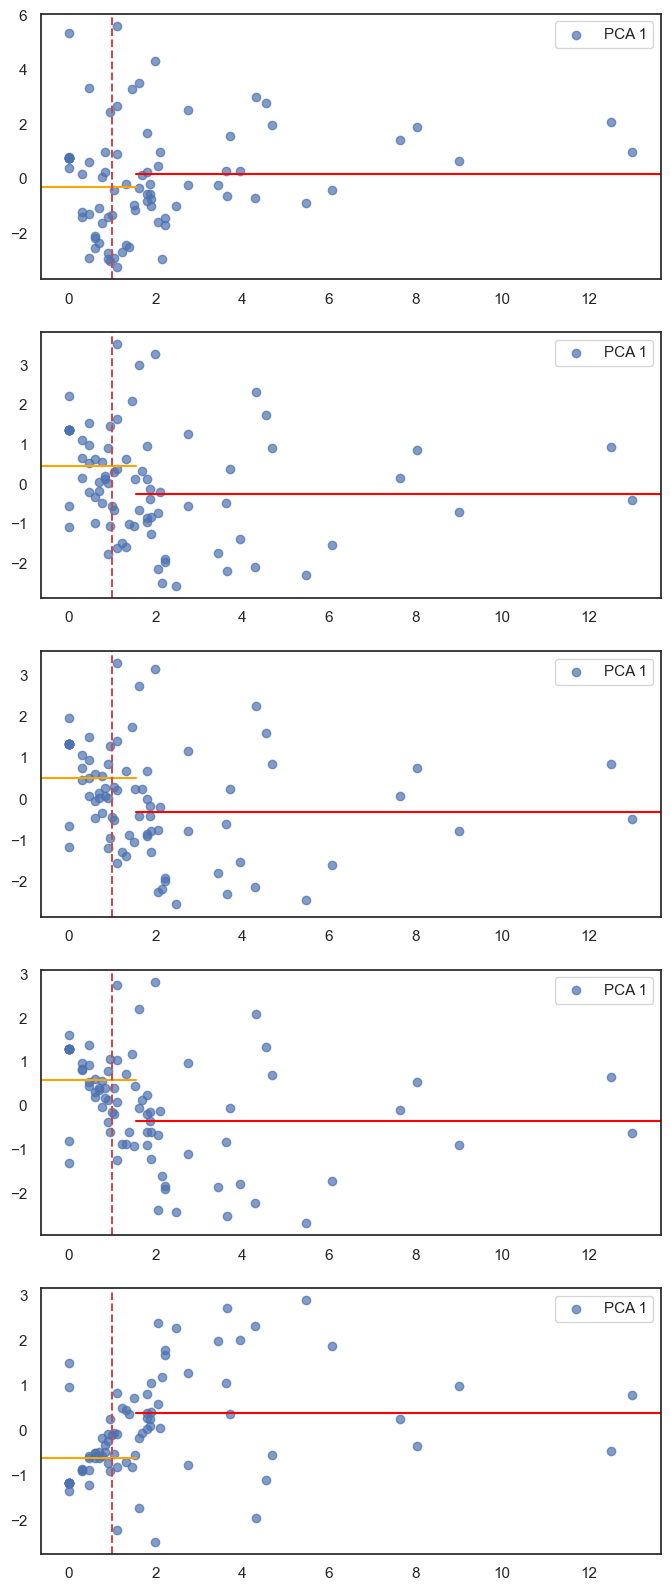

In [182]:
plt.figure(figsize=(8,4))
to_m_counts = np.zeros(len(count_arrs))
for i in range(len(count_arrs)):
    to_m_counts[i] = np.log(count_arrs[i][['M1', 'M2']].sum().sum() + 1) / np.log(10)
to_m_counts[np.where(to_m_counts > 80)] = 0
plt.hist(to_m_counts, bins=100)
plt.axvline(1, c="r", linestyle="--")

fig, axs = plt.subplots(len(ks), 1, figsize=(8,20))
for i in range(len(ks)):
    k_arg = ks[i]
    pca, tmat_transformed, _ = get_tm_pca_transformed(k_arg)
    for j in range(1):
        mean_lt_1 = tmat_transformed[:,j][to_m_counts < 1].mean()
        mean_gt_1 = tmat_transformed[:,j][to_m_counts >= 1].mean()
        print(mean_lt_1, mean_gt_1)
        axs[i].axhline(mean_lt_1, xmin=0, xmax=2/13, c = "orange")
        axs[i].axhline(mean_gt_1, xmin=2/13, xmax=1, c="red")
        axs[i].scatter(to_m_counts, tmat_transformed[:, j], alpha=.7, label="PCA %d" % (j+1))
    axs[i].axvline(1, c="r", linestyle="--")
#     axs[i][0].scatter(to_m_counts, tmat_transformed[:, 1])
#     axs[i][1].axvline(1, c="r", linestyle="--")
    axs[i].legend()
plt.show()

In [206]:
def get_labels_from_indices(labels):
    return list(map(lambda i: trans_labels[i], [1,2]))

In [205]:
list(map(lambda i: trans_labels[i], [1,2]))

['RW->M2', 'RW->M1']

Correlation [[0.06682842 0.07397736 0.00445628 0.04662272 1.        ]]
Correlation [0.59270213 0.61049779 0.07397736]
Correlation 0.0668 0.0740 0.0045 0.0466 
[[1.00000000e+00 4.46603770e-03 5.47265029e-03 1.98584661e-05
  2.17367763e-03]
 [4.46603770e-03 1.00000000e+00 5.92980598e-01 7.37394696e-01
  7.19263375e-01]
 [5.47265029e-03 5.92980598e-01 1.00000000e+00 3.51295814e-01
  3.72707556e-01]
 [1.98584661e-05 7.37394696e-01 3.51295814e-01 1.00000000e+00
  9.83418840e-01]
 [2.17367763e-03 7.19263375e-01 3.72707556e-01 9.83418840e-01
  1.00000000e+00]]


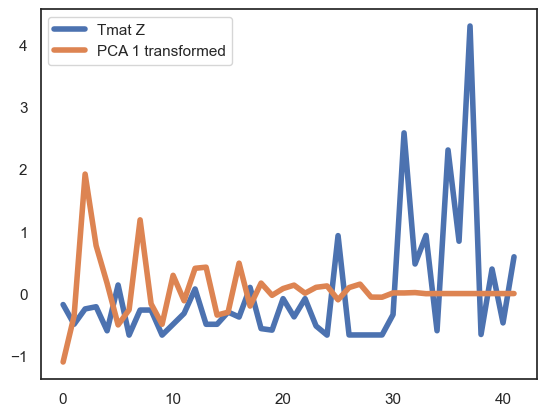

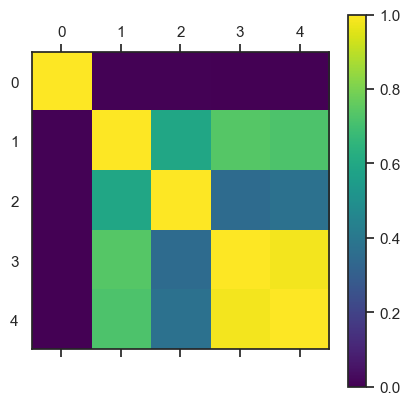

In [259]:
pca, tmat_z, tmat_transformed, tmat_counts = get_tm_pca_transformed(k_arg)
Y0 = tmat_z[0,:]
Y1 = pca.components_[0,:]
Y = tmat_transformed[0,:] #np.abs(pca.components_[0,:])
# X1 = [sum()]
X1 = tmat_counts[tmat_counts < 10].count().values / tmat_counts.shape[1]
X2 = tmat_counts[tmat_counts < 10].std().values
X2 /= X2.max()
X3 = tmat_counts.std().values
X3 /= X3.max()
X4 = tmat_counts[tmat_counts >= 10].std().values
X4 /= X4.max()
plt.plot(Y0, linewidth = 4, label = "Tmat Z")
# plt.plot(Y1, linewidth = 4, label = "PCA 1 coeffs")
plt.plot(Y, linewidth = 4, label = "PCA 1 transformed")
# plt.plot(X1, label= "Count less than ten")
# plt.plot(X2, label= "Std of those less than ten")
# plt.plot(X3, label= "Raw std")
# plt.plot(X4, label= "Std of those greater than 10")
Y_data = tmat_transformed
print("Correlation", np.corrcoef([X1, X2, X3, X4], Y)[-1:])
print("Correlation", np.corrcoef([ X2, X3, X4], Y)[0][1:])
plt.legend()
print("Correlation", end = " ")
for X in [X1, X2, X3, X4]:
    print("%.4f" % np.corrcoef(X, Y)[0][1], end=" ")
print()
corrmatrix = np.corrcoef([Y, X1, X2, X3, X4]) ** 2
plt.matshow(corrmatrix, cmap="viridis", vmin=0, vmax=1)
print(corrmatrix)
plt.colorbar()

# Step 2: comparing this back to the original z scores
tmat_counts



plt.show()

What we see above is there is a significant correlation between the count of the datapoints less than 10 and the standard deviation of those counts. This makes sense however as less counts less than 10 imply a greater dispersal of these counts. What I want instead are correlations between the count less than 10 / deviation of counts / z score of counts compared to the z score of the transition probability.

### ideas
* linear regression of standard deviation of datapoints with samples < 10 vs. PCA explained variance
* statistical test of how much variance is driven by counts < 10
* linear regession of feature value (or standard devation??) vs. samples calculated on those features 
* uncertainty based on tissue location?

In [254]:
trans_labels = []
toy = lg_to_countarr[1]
for i in range(toy.shape[0]):
    for j in range(toy.shape[1]):
        if i != j:
            trans_labels.append(toy.index.values[i] + "->" + toy.columns.values[j])

trans_labels.append("LLReseeding")
trans_labels.append("To_M")
trans_labels.append('To_Liv')
trans_labels.append('LL_to_RL')
trans_labels.append("RL_to_LL")
trans_labels.append("IntraLung")
trans_labels.append('IntraM')
trans_labels.append('ToRL')
trans_labels.append("PrimarySeeding")
trans_labels.append("FromM1")
trans_labels.append("FromM2")
trans_labels.append("FromMed")

# unravel and drop diagonal values
def get_tm_pca_transformed(k_arg):
    transition_vectors = []
    transition_vectors_counts = []
    k = 0
    for i in range(len(lgs)):
        lg, tm, count_arr = lgs[i], count_arrs_plus_one[i][k_arg], count_arrs[i]
    # for lg, tm in lg_to_countarr.items():
        tv = []
        
        tv_counts = []

    #     lgs.append(lg)

        for i in range(tm.shape[0]):
    #         print(tm)
    #         if tm.values[i] == np.nan:
    #             continue
            for j in range(tm.shape[1]):
                if i != j:    
                    tv.append(tm.iloc[i, j])
                    tv_counts.append(count_arr.iloc[i, j])
        tv.append(np.sum(tm['LL'].values)) # Currently is just summing the 
        tv.append(np.sum(tm[['M1', 'M2']].sum())) # TODO: histogram of M
        tv.append(np.sum(tm['Liv'].values))
        tv.append(np.sum(tm.loc['LL', ['RW', 'RE']].sum()))
        tv.append(np.sum(tm.loc[['RE', 'RW'], 'LL'].sum()))
        tv.append(np.sum(tm.loc[['LL', "RE", "RW"], ['LL', 'RE', 'RW']].sum()))
        tv.append(np.sum(tm.loc[['M1', 'M2'], ['M1', 'M2']].sum()))
        tv.append(np.sum(tm[['RE', 'RW']].sum()))
        
        tv_counts.append(np.sum(count_arr['LL'].values))
        tv_counts.append(np.sum(count_arr[['M1', 'M2']].sum()))
        tv_counts.append(np.sum(count_arr['Liv'].values))
        tv_counts.append(np.sum(count_arr.loc['LL', ['RW', 'RE']].sum()))
        tv_counts.append(np.sum(count_arr.loc[['RE', 'RW'], 'LL'].sum()))
        tv_counts.append(np.sum(count_arr.loc[['LL', "RE", "RW"], ['LL', 'RE', 'RW']].sum()))
        tv_counts.append(np.sum(count_arr.loc[['M1', 'M2'], ['M1', 'M2']].sum()))
        tv_counts.append(np.sum(count_arr[['RE', 'RW']].sum()))


        tot = count_arr.sum().sum()
        tot = max(tot, 1)
    
        LL_density = np.sum(count_arr.loc['LL',:]) / tot #[count_arr.loc['LL', i] / tot for i in count_arr.columns])
        M1_density = np.sum(count_arr.loc['M1',:]) / tot #[count_arr.loc['M1', i] / tot for i in count_arr.columns])
        M2_density = np.sum(count_arr.loc['M2',:]) / tot #[count_arr.loc['M2', i] / tot for i in count_arr.columns])
        
        tv.append(LL_density)
        tv.append(M1_density)
        tv.append(M2_density)
        tv.append(M1_density + M2_density)
        
        tv_counts.append(LL_density * tot)
        tv_counts.append(M1_density * tot)
        tv_counts.append(M2_density * tot)
        tv_counts.append((M1_density + M2_density) * tot)

        transition_vectors.append(np.nan_to_num(tv))
        transition_vectors_counts.append(np.nan_to_num(tv_counts))

        k += 1

    tmat = np.array(transition_vectors)
    tmat_counts = np.array(transition_vectors_counts)


    tmat = pd.DataFrame(tmat, columns=trans_labels)
    tmat_counts = pd.DataFrame(tmat_counts, columns=trans_labels)

    tmat_z = tmat \
        .subtract(tmat.mean(axis=1), axis=0) \
        .divide(tmat.std(axis=1), axis=0)

    tmat_z = np.nan_to_num(tmat_z)

    pca = PCA()
    tmat_transformed = pca.fit_transform(tmat_z)
    return pca, tmat_z, tmat_transformed, tmat_counts

def plot_pca_components(pca, ax=None):
    if ax is None:
        ax = plt.gca()
    loadings = np.transpose(pca.components_[0:2, :])
    var_explained = pca.explained_variance_ratio_

    ax.scatter(np.arange(1, len(var_explained)+1), var_explained, color='black')
    ax.plot(np.arange(1, len(var_explained)+1), var_explained, color='red')

#     pc1_top_loading = np.argmax(loadings[:,0])
#     pc2_top_loading = np.argmax(loadings[:,1])

def plot_pca_vectors(pca):
    
    h = plt.figure(figsize = (6, 6))
    coeff = np.transpose(pca.components_)

    iis = np.argsort(np.abs(coeff[:, d1]))[::-1][:5]
    iis = np.unique(np.concatenate((iis, np.argsort(np.abs(coeff[:, d2]))[::-1][:5])))
    for i in iis:
        plt.arrow(0, 0, coeff[i,d1], coeff[i,d2], color = 'r',alpha = 0.5)
        plt.text(coeff[i,d1]* 1.05, coeff[i,d2] * 1.05, trans_labels[i], color = 'g', ha = 'center', va = 'center')

    plt.xlim(-0.8, 0.8)
    plt.ylim(-0.9, 0.8)

    plt.title("k=0.2 PCA")
    plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
    plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))

    # plt.savefig('biplot_transmat.pc{}_{}.eps'.format(d1+1, d2+1))

    plt.show()

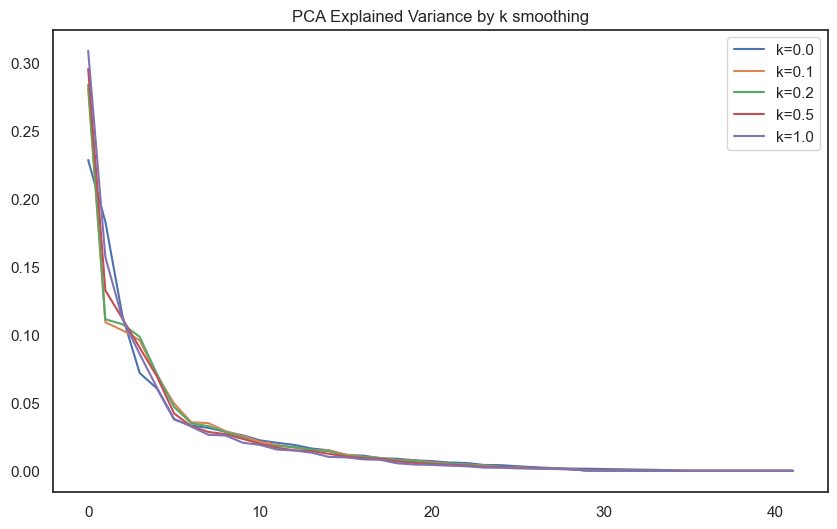

In [198]:
fig, axs = plt.subplots(1, figsize=(10,6))
for i in range(len(ks)):
#     ax = axs[i]
    k_arg = ks[i]
    pca, tmat_transformed, _ = get_tm_pca_transformed(k_arg)
    plt.plot(pca.explained_variance_ratio_, alpha=1, label="k=%.1f" % k_arg)
#     ax.set_title("k=%.1f" % k_arg)
plt.legend()
plt.title("PCA Explained Variance by k smoothing")
plt.show()

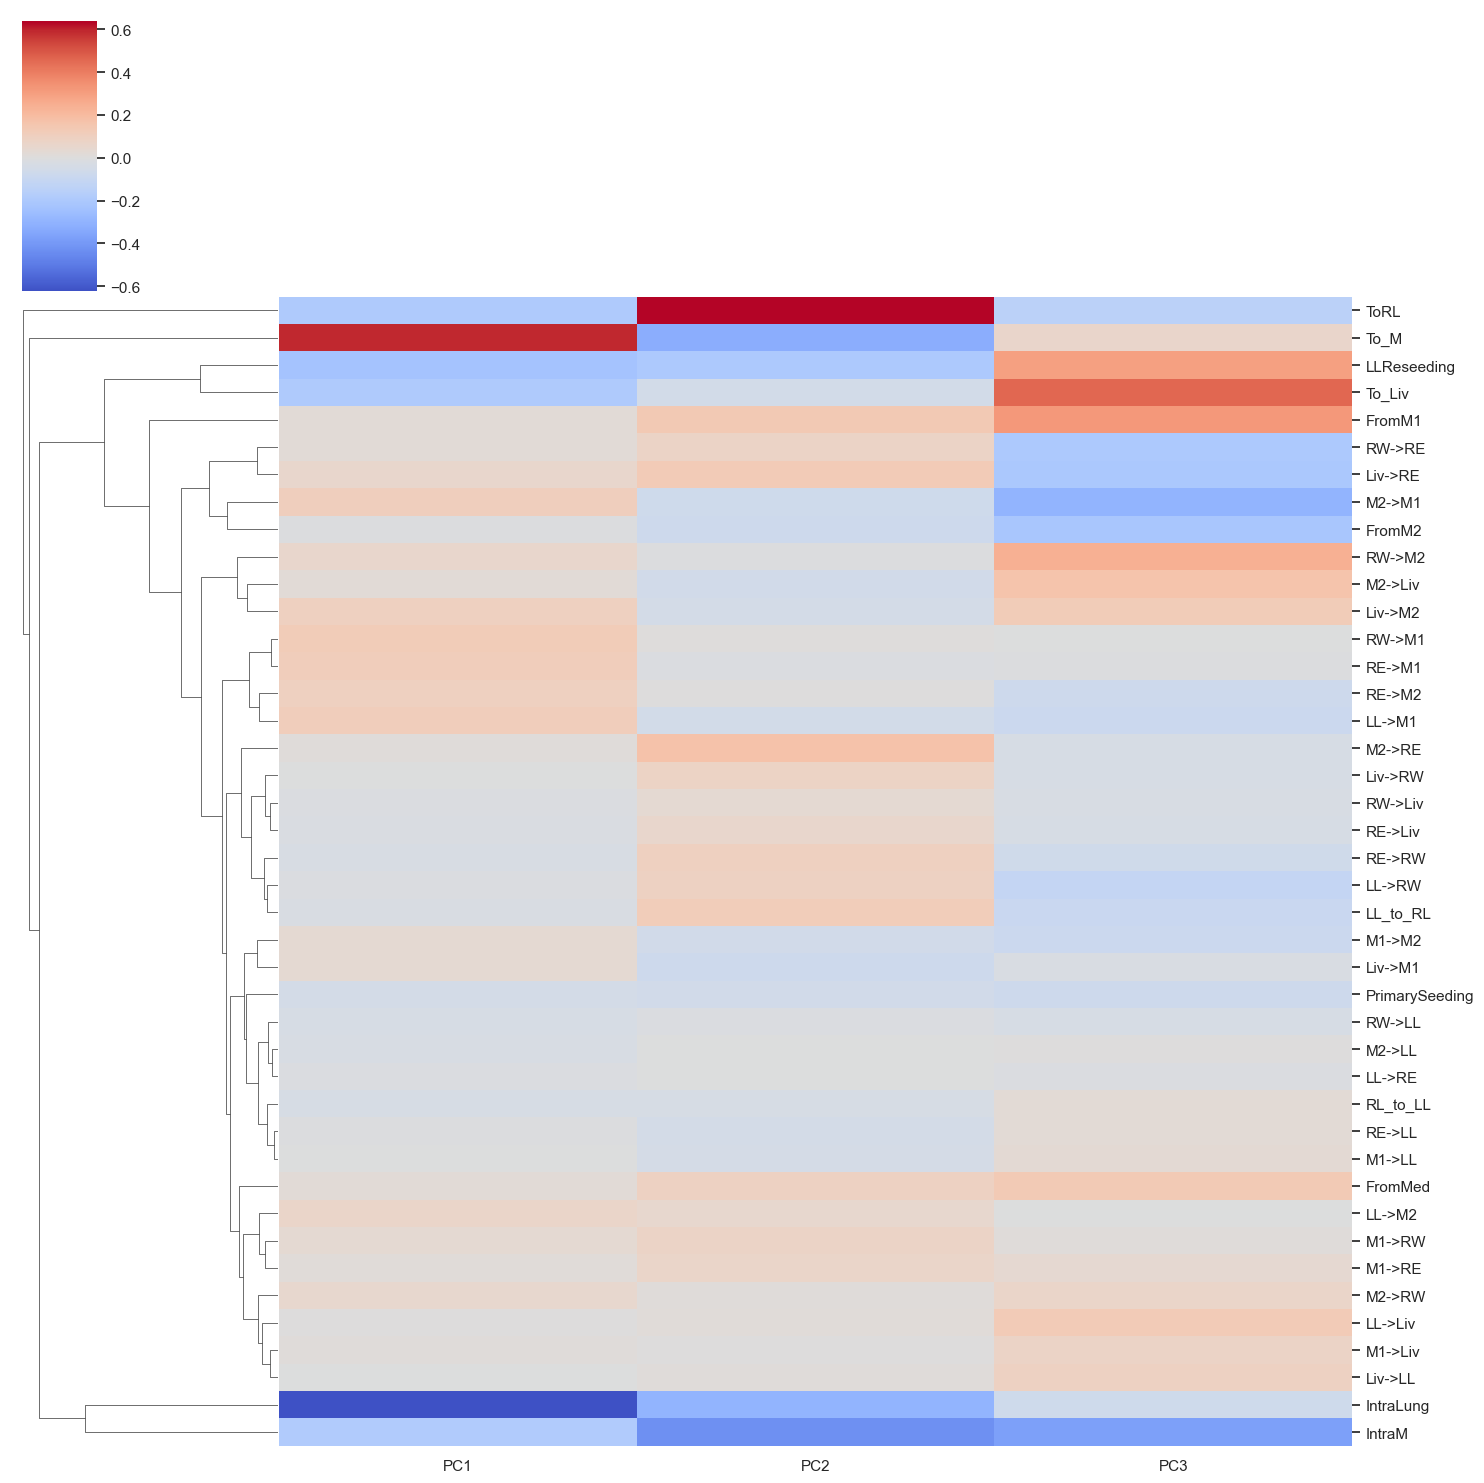

(42, 42)


,PC1,PC2,PC3
IntraLung,-0.621668,-0.300529,-0.065785
LLReseeding,-0.231977,-0.200545,0.295634
ToRL,-0.192848,0.638204,-0.144597
To_Liv,-0.192157,-0.051443,0.456171
IntraM,-0.184422,-0.426302,-0.373500
PrimarySeeding,-0.050220,-0.055972,-0.072232
RL_to_LL,-0.036001,-0.033145,0.025834
RW->LL,-0.033159,-0.015506,-0.031158
RE->RW,-0.028764,0.098611,-0.063848
M2->LL,-0.027091,-0.005614,-0.000404


In [37]:
coeff = np.transpose(pca.components_)
coeffdf = pd.DataFrame(coeff, index=trans_labels)
coeffdf.columns = ["PC" + str(x + 1) for x in range(coeff.shape[1])]

cm = sns.clustermap(coeffdf.iloc[:, :3], cmap = 'coolwarm', col_cluster=False, figsize = (15, 15), center=0)
# cm.cax.set_visible(False)
#plt.tight_layout()
plt.savefig('transmatpca_loadings.withcolorbar.eps')
plt.show()

print(coeffdf.shape)
coeffdf.iloc[:,:3].sort_values(by = 'PC1')

In [260]:
colors_dict = dict(zip(lg_meta.LineageGroup, lg_meta.sampleID))
colors = [colors_dict[lg] for lg in lgs]
def plot_pca_samples(pca, tmat_transformed, k_arg, ax, d1=0, d2=1):
    sns.set_style("white")

    x, y = tmat_transformed[:,d1], tmat_transformed[:, d2]
    sizes = dict(zip(lgs, x))
    ss = dict(zip(lgs, y))
    labs = lgs

    scalex = 1.0/(x.max() - x.min())
    scaley = 1.0/(y.max() - y.min())
    
    colors = [colors_dict[lg] for lg in lgs]

    sns.scatterplot(x=x*scalex, y=y*scaley, hue=colors, ax=ax)
    ax.set_title("PCA of Transition Matrices k=%.1f" % k_arg)


    for i in labs:
        ax.annotate(i, (sizes[i]*scalex+0.01, ss[i]*scaley+0.01), fontsize=6, color='grey')

    ax.set_xlabel("PC{} ({}% Explained)".format(d1+1, round(pca.explained_variance_ratio_[d1]*100,1)))
    ax.set_ylabel("PC{} ({}% Explained)".format(d2+1, round(pca.explained_variance_ratio_[d2]*100,1)))
#     plt.savefig('transmatpca_pc{}_{}.eps'.format(d1+1, d2+1))

def plot_pca_arrows(pca, k_arg, ax, d1=0, d2=1):
#     d1, d2 = 0, 1

    coeff = np.transpose(pca.components_)

    iis1 = np.argsort(np.abs(coeff[:, d1]))[::-1][:5]
    iis2 = np.argsort(np.abs(coeff[:, d2]))[::-1][:5]
    iis = np.unique(np.concatenate((iis1, iis2)))
    for i in iis:
        if i in iis1:
            c = "blue"
        else:
            c = "orange"
        ax.arrow(0, 0, coeff[i,d1], coeff[i,d2], color = c,alpha = 0.5)
        ax.text(coeff[i,d1]* 1.05, coeff[i,d2] * 1.05, trans_labels[i], fontsize=8, color = c, ha = 'center', va = 'center')

    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.9, 0.8)

    ax.set_title("k=%.1f PCA" % k_arg)
    ax.set_xlabel("PC{} ({}% Explained)".format(d1+1, round(pca.explained_variance_ratio_[d1]*100,1)))
    ax.set_ylabel("PC{} ({}% Explained)".format(d2+1, round(pca.explained_variance_ratio_[d2]*100,1)))

    # plt.savefig('biplot_transmat.pc{}_{}.eps'.format(d1+1, d2+1))



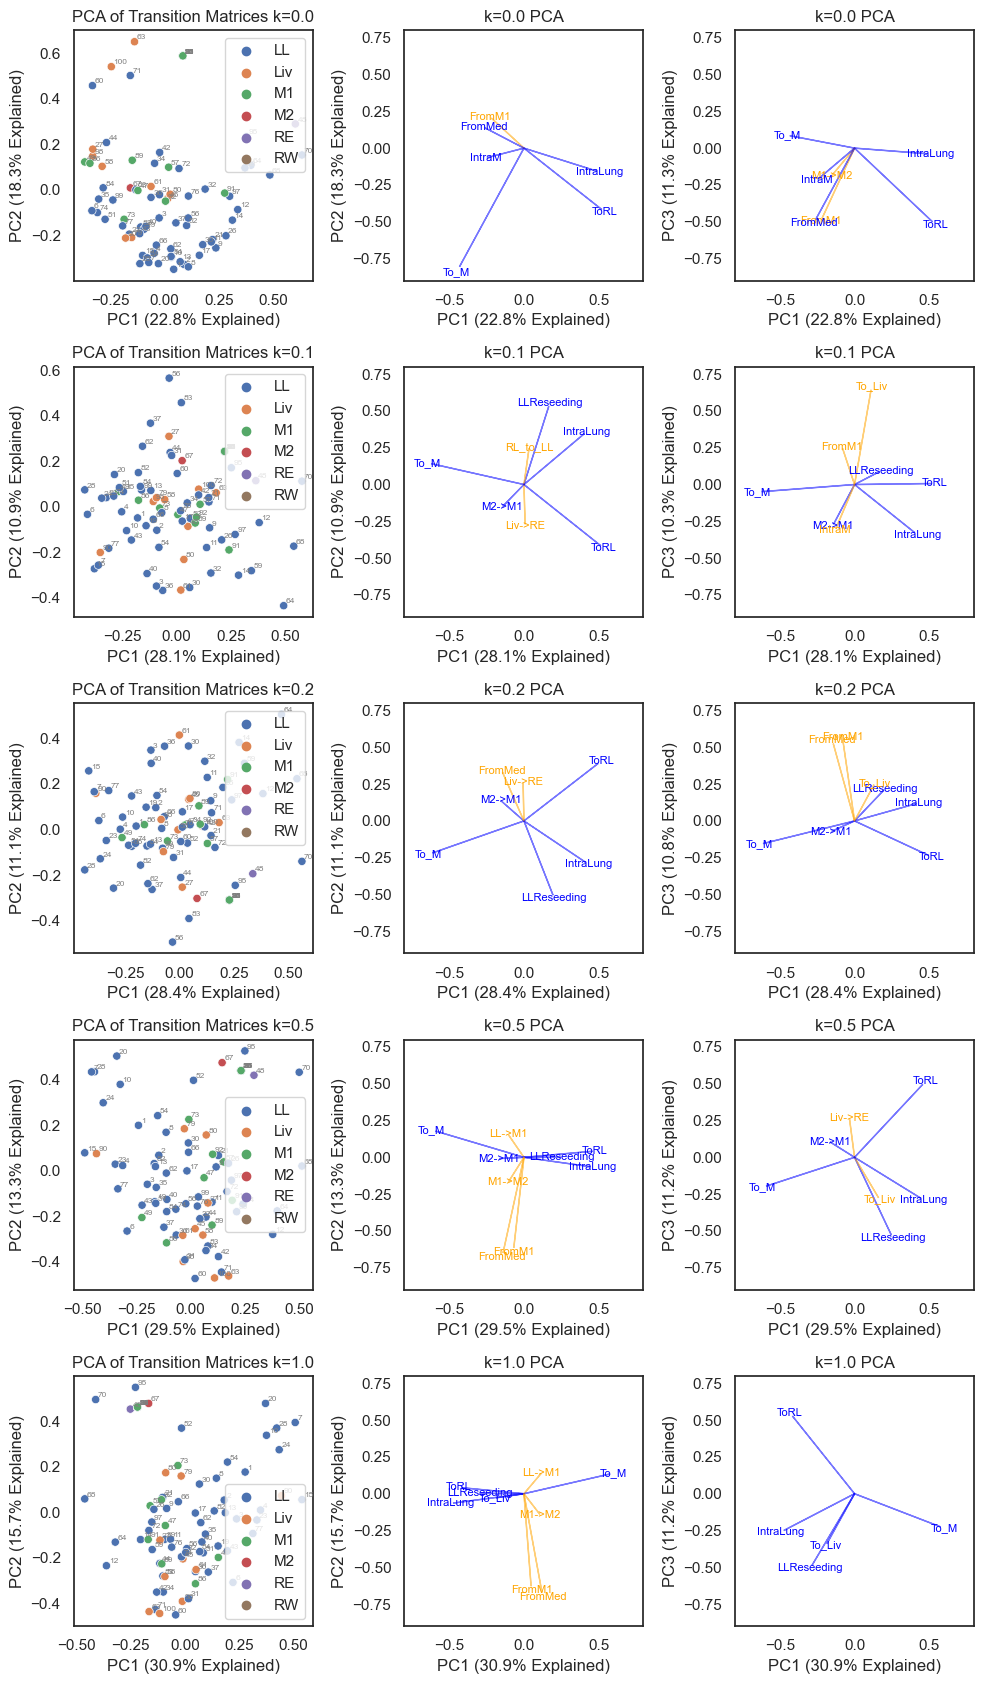

In [263]:
fig, axs = plt.subplots(len(ks), 3, figsize=(10, 17))
for i in range(len(ks)):
    k_arg = ks[i]
    ax1, ax2, ax3 = axs[i]
    pca, _, tmat_transformed, _ = get_tm_pca_transformed(k_arg)
    plot_pca_samples(pca, tmat_transformed, k_arg, ax1, d1=0, d2=1)
    plot_pca_arrows(pca, k_arg, ax2, d1=0, d2=1)
    plot_pca_arrows(pca, k_arg, ax3, d1=0, d2=2)
fig.tight_layout()
plt.show()

# TODO:
1. Histogram of non-self transition counts to see the original distribution
2. Come up with new/better ways of uncertainty weighting
3. Redo oriignal results to line up with what we see in the paper 
4. Dot product/quantitative comparison of new PCAs vs. old PCAs

In [38]:
print(lg_to_countarr.keys())

dict_keys([14, 95, 45, 99, 37, 49, 66, 1, 82, 52, 20, 71, 94, 44, 15, 67, 19, 98, 48, 36, 83, 70, 21, 35, 64, 3, 68, 47, 97, 22, 73, 80, 2, 34, 46, 96, 17, 72, 23, 51, 86, 28, 56, 79, 24, 91, 9, 10, 62, 78, 57, 29, 74, 11, 8, 90, 40, 32, 63, 4, 77, 58, 26, 54, 84, 60, 7, 31, 43, 12, 27, 59, 89, 76, 85, 100, 30, 61, 6, 13, 42, 92])


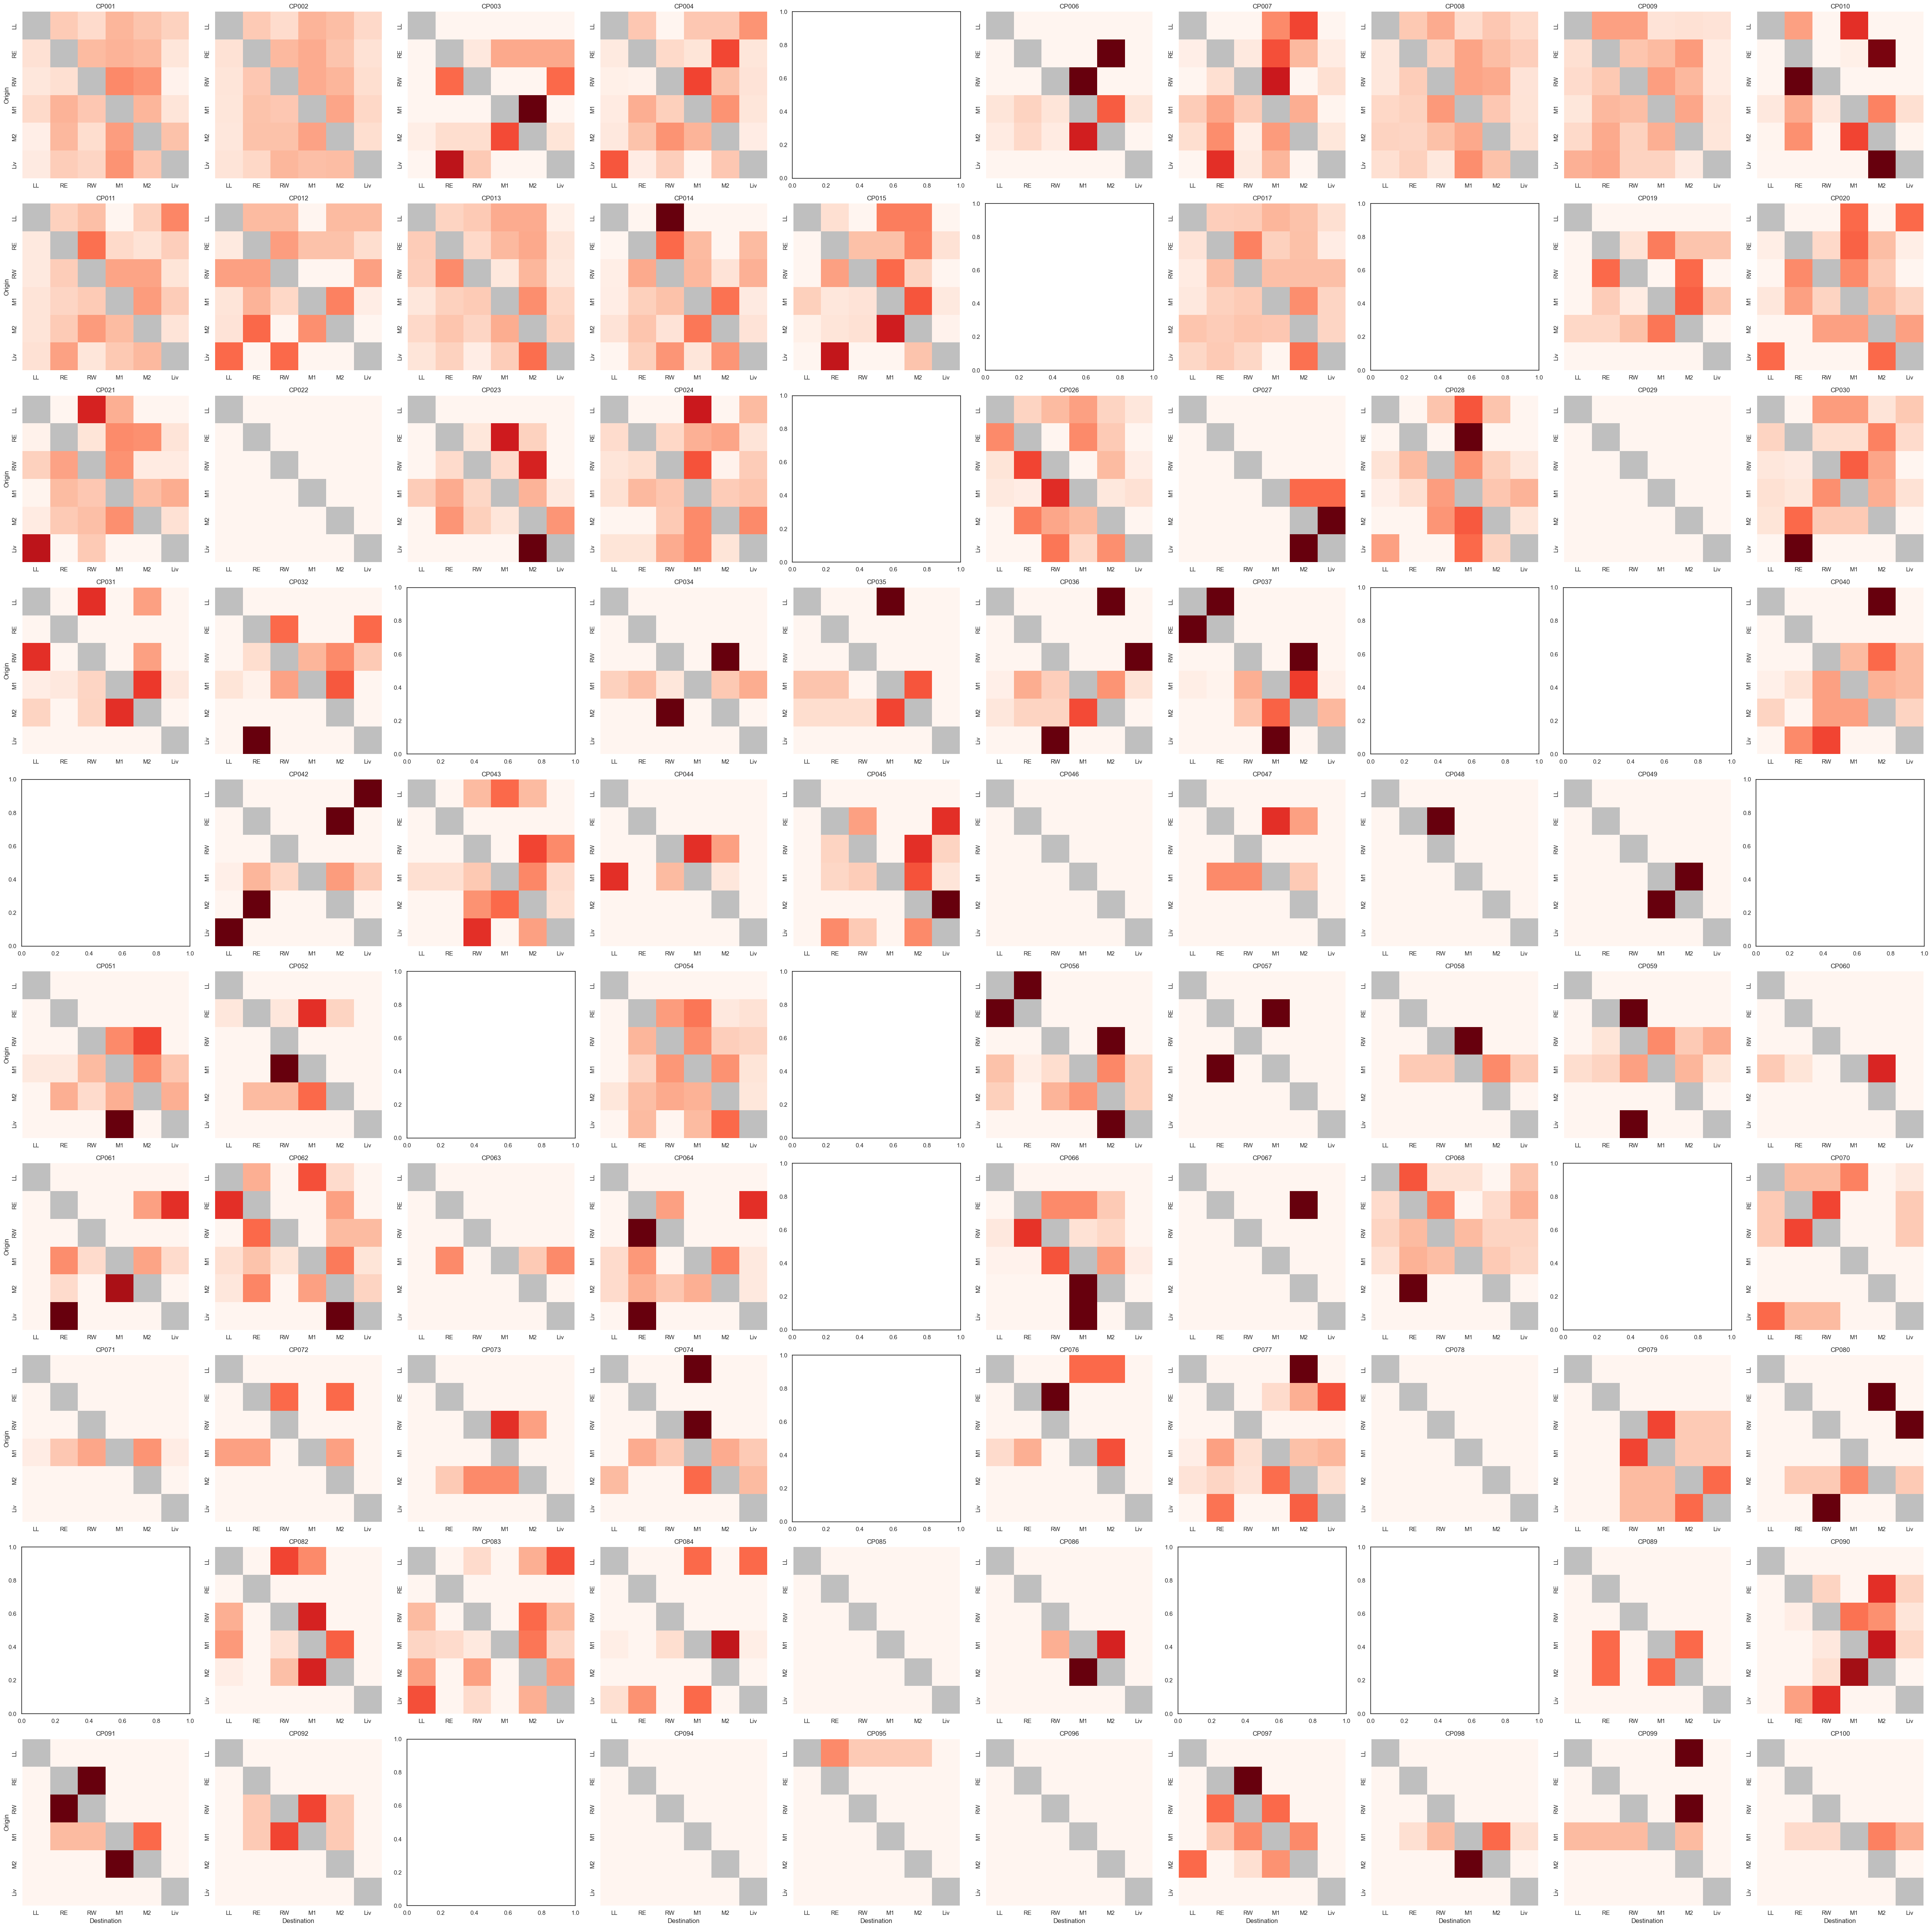

In [35]:
# generate all transition matrices 
fig, axarr = plt.subplots(nrows = 10, ncols=10, figsize = (50, 50))
mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)


for j in range(1, 101):
    
    if j not in lg_to_countarr:
        continue
        
    x = int((j-1)/10)
    y = int((j-1)%10)
    
    
    res = lg_to_countarr[j].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
    g = sns.heatmap(res, mask = mask, cmap="Reds", ax=axarr[x, y], square=True, vmin = 0, vmax=1.0, cbar=False)
    # remove colorbar
    if y == 0:
        axarr[x,y].set_ylabel("Origin")
    if x == 9:
        axarr[x,y].set_xlabel("Destination")
    
    # add CP annotation
    if j < 10:
        axarr[x,y].set_title('CP00' + str(j))
    elif j < 100:
        axarr[x,y].set_title('CP0' + str(j))
    else:
        axarr[x,y].set_title('CP' + str(j))
    g.set_facecolor('#bfbfbf')
    
plt.subplots_adjust(hspace=0.7, wspace=0.1)
plt.tight_layout()
# plt.savefig('all_clone_transmat.eps')
plt.show()

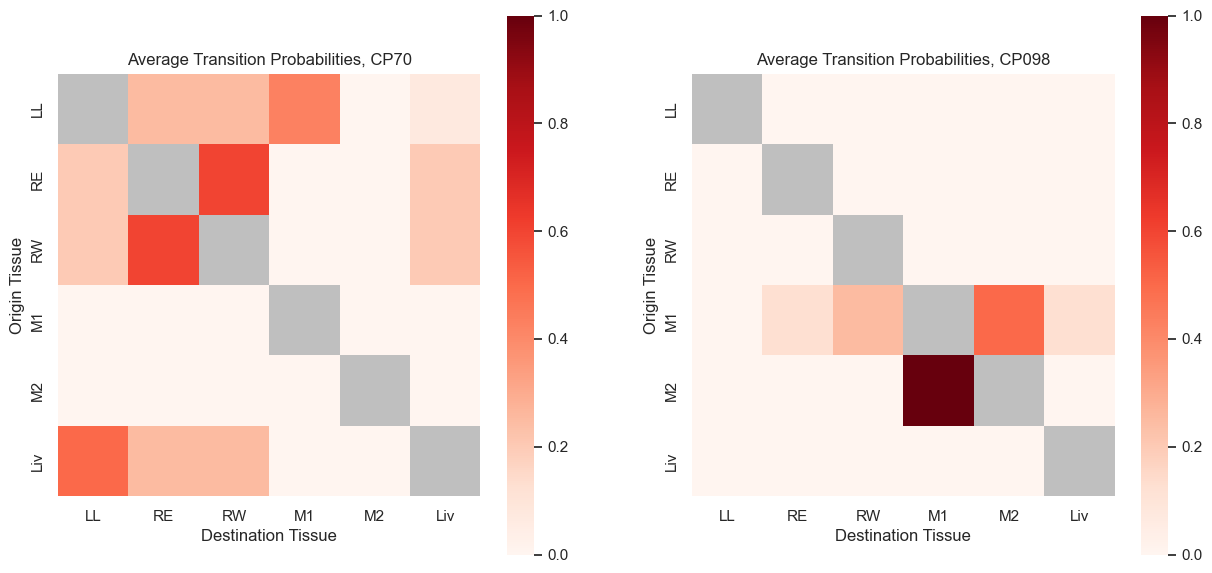

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)

lg1 = 70


res = lg_to_countarr[lg1].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
g = sns.heatmap(res, mask = mask, cmap="Reds", ax=axes[0], square=True, vmin = 0, vmax=1.0)
axes[0].set_ylabel("Origin Tissue")
axes[0].set_xlabel("Destination Tissue")
axes[0].set_title("Average Transition Probabilities, CP" + str(lg1))
g.set_facecolor('#bfbfbf')

lg2 = 98

res = lg_to_countarr[lg2].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
g = sns.heatmap(res, mask = mask, 
                cmap="Reds", ax=axes[1], square=True, vmin=0, vmax=1.0)
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Average Transition Probabilities, CP0" + str(lg2))
g.set_facecolor('#bfbfbf')

plt.savefig("cp{}_cp{}_tmat.eps".format(str(lg1), str(lg2)))


### Example for computing a subtree's transition matrix

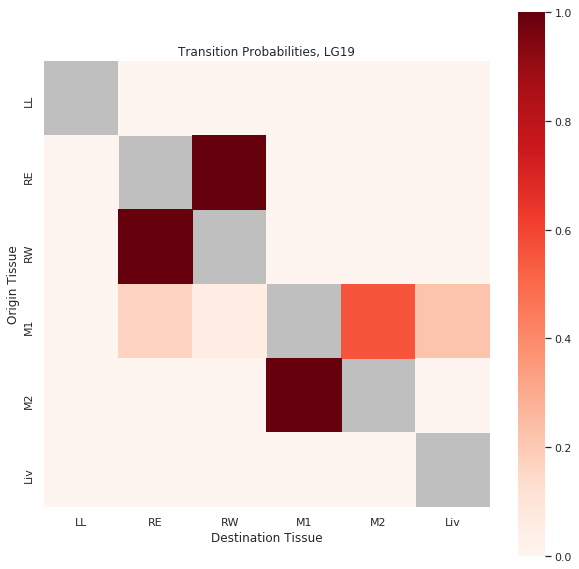

In [34]:
import cassiopeia.TreeSolver.utilities as util 

lg = lg_to_tree[19]
cm = lg_to_cm[19]

def get_leaves(tree, x):
    
    all_prog = [node for node in nx.dfs_preorder_nodes(tree, x)]
    return [n.name for n in all_prog if tree.out_degree(n) == 0 and tree.in_degree(n) == 1]
    
plg = lg.post_process(cm).network

c1 = "M2.GTGAAGGAGCTGTCTA-1"
c2 = "M2.TGCACCTCACTACAGT-1"
c3 = "M2.TCACAAGTCGGCTACG-1"
c4 = "RE.GATGAAAAGTAGCCGA-1"

root = [n for n in plg if plg.in_degree(n) == 0][0]
subns = []
plg2 = nx.DiGraph()
for child in plg.successors(root):
    all_children = get_leaves(plg, child)
    if c1 in all_children or c2 in all_children or c3 in all_children or c4 in all_children:
        subn = plg.subgraph([node for node in nx.dfs_preorder_nodes(plg, child)])
        plg2 = nx.compose(plg2, subn)

pseudo_roots = [n for n in plg2 if plg2.in_degree(n) == 0]
plg2.add_edges_from([(root, pr) for pr in pseudo_roots])

nw = util.convert_network_to_newick_format(plg2)
with open('sublg19_tree.nwk', 'w') as f:
    f.write(nw)

leaves = [n for n in plg2 if plg2.out_degree(n) == 0]

count_arr = reconstruct_states.fitch_count(plg2, lg_meta['sampleID'])
np.fill_diagonal(count_arr.values,0)

mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)

count_arr = count_arr.apply(lambda x: x / max(1, x.sum()), axis=1)
res = count_arr.loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
h = plt.figure(figsize=(10, 10))
np.fill_diagonal(count_arr.values,np.nan)
g = sns.heatmap(res, mask = mask, cmap="Reds",  square=True)
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Transition Probabilities, LG" + str(19))
g.set_facecolor('#bfbfbf')
plt.savefig('cp019_sub_tmat.eps')
plt.show()